In [71]:
import pandas as pd
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
warnings.simplefilter("ignore")
from scipy.signal import find_peaks

In [72]:
# Import data
data = pd.read_csv("data/data_Q1.csv")
df_wars = pd.DataFrame(data)
df_movies = pd.read_csv("data/filtered_movie_data.csv")

In [73]:
'''
def plot_genre_counts(genre_counts_df, year):
    sns.barplot(data=genre_counts_df.head(30), x="Genre", y="Count")
    name_plot("Number of Movies Released", f"Movies of each genre released in {year}")

# Function to iterate through each unique war and plot the genre counts over time
def plot_all_war_genre_trends(df):
    # Get unique war names from the 'WarName' column
    unique_war_names = final_df['WarName'].unique()

    # Iterate through each unique war name
    for war_name in unique_war_names:
        years = get_event_years(final_df, war_name)  # Pass war_name as argument
        
        if years:
            year0, year1, year2, year3, year4 = years
            
            # Get counts for each year
            counts_year0, total_movies_year0 = count_genres_by_year(df, year0)
            counts_year1, total_movies_year1 = count_genres_by_year(df, year1)
            counts_year2, total_movies_year2 = count_genres_by_year(df, year2)
            counts_year3, total_movies_year3 = count_genres_by_year(df, year3)
            counts_year4, total_movies_year4 = count_genres_by_year(df, year4)
            
            # Plot genre counts for each year
            plot_genre_counts(counts_year0, year0)
            plot_genre_counts(counts_year1, year1)
            plot_genre_counts(counts_year2, year2)
            plot_genre_counts(counts_year3, year3)
            plot_genre_counts(counts_year4, year4)

plot_all_war_genre_trends(df)
'''

'\ndef plot_genre_counts(genre_counts_df, year):\n    sns.barplot(data=genre_counts_df.head(30), x="Genre", y="Count")\n    name_plot("Number of Movies Released", f"Movies of each genre released in {year}")\n\n# Function to iterate through each unique war and plot the genre counts over time\ndef plot_all_war_genre_trends(df):\n    # Get unique war names from the \'WarName\' column\n    unique_war_names = final_df[\'WarName\'].unique()\n\n    # Iterate through each unique war name\n    for war_name in unique_war_names:\n        years = get_event_years(final_df, war_name)  # Pass war_name as argument\n        \n        if years:\n            year0, year1, year2, year3, year4 = years\n            \n            # Get counts for each year\n            counts_year0, total_movies_year0 = count_genres_by_year(df, year0)\n            counts_year1, total_movies_year1 = count_genres_by_year(df, year1)\n            counts_year2, total_movies_year2 = count_genres_by_year(df, year2)\n            cou

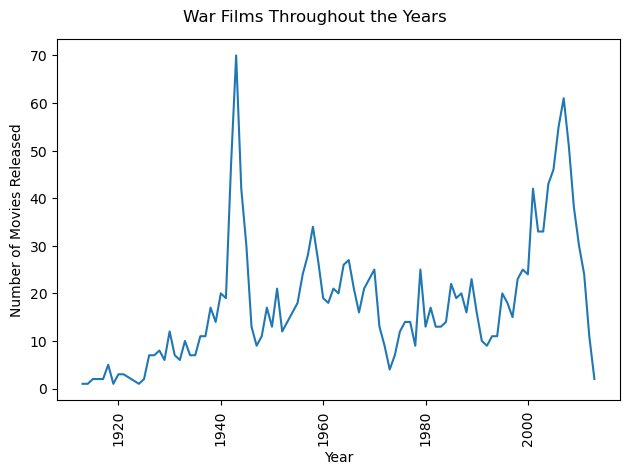

    Year  Count
0   1943     70
1   2007     61
2   2006     55
3   2008     51
4   1942     47
5   2005     46
6   2004     43
7   1944     42
8   2001     42
9   2009     38
10  1958     34
11  2002     33
12  2003     33
13  1945     30
14  2010     30
15  1957     28
16  1959     27
17  1965     27
18  1964     26
19  1970     25
    Year  Count
0   1913      1
1   1914      1
2   1919      1
3   1924      1
4   1915      2
5   1917      2
6   1925      2
7   2013      2
8   1920      3
9   1921      3
10  1973      4
11  1918      5
12  1929      6
13  1932      6
14  1926      7
15  1927      7
16  1931      7
17  1934      7
18  1935      7
19  1974      7


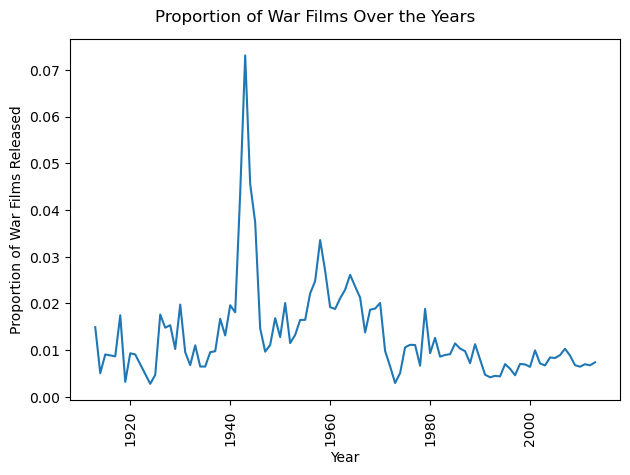

    Year  Count  Total  Proportion
27  1943     70    958    0.073069
28  1944     42    922    0.045553
26  1942     47   1078    0.043599
29  1945     30    803    0.037360
42  1958     34   1013    0.033564
43  1959     27   1001    0.026973
48  1964     26    995    0.026131
41  1957     28   1129    0.024801
49  1965     27   1142    0.023643
47  1963     20    871    0.022962
40  1956     24   1083    0.022161
50  1966     21    989    0.021234
46  1962     21    995    0.021106
54  1970     25   1243    0.020113
35  1951     21   1045    0.020096
14  1930     12    607    0.019769
24  1940     20   1019    0.019627
44  1960     19    989    0.019211
53  1969     23   1216    0.018914
63  1979     25   1327    0.018839
    Year  Count  Total  Proportion
8   1924      1    355    0.002817
57  1973      4   1340    0.002985
5   1919      1    309    0.003236
76  1992      9   2139    0.004208
78  1994     11   2499    0.004402
77  1993     11   2432    0.004523
81  1997     15   32

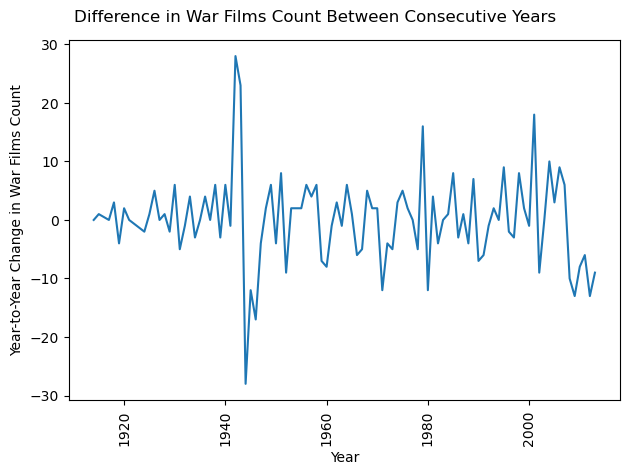

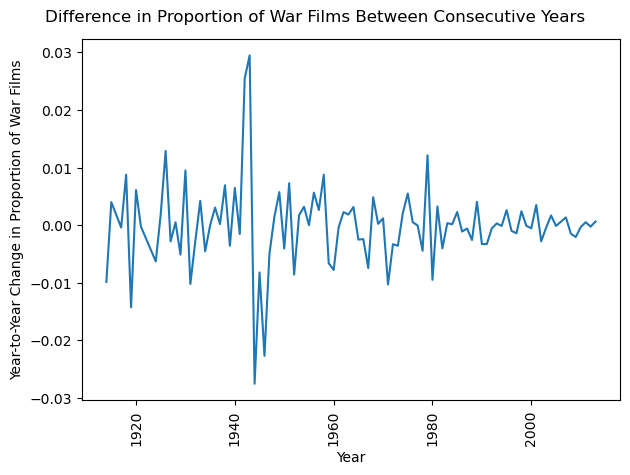

    Year  Count_diff
26  1942        28.0
27  1943        23.0
85  2001        18.0
63  1979        16.0
88  2004        10.0
79  1995         9.0
90  2006         9.0
35  1951         8.0
69  1985         8.0
82  1998         8.0
73  1989         7.0
14  1930         6.0
22  1938         6.0
24  1940         6.0
33  1949         6.0
40  1956         6.0
42  1958         6.0
48  1964         6.0
91  2007         6.0
10  1926         5.0
    Year  Count_diff
28  1944       -28.0
30  1946       -17.0
93  2009       -13.0
96  2012       -13.0
29  1945       -12.0
55  1971       -12.0
64  1980       -12.0
92  2008       -10.0
36  1952        -9.0
86  2002        -9.0
97  2013        -9.0
44  1960        -8.0
94  2010        -8.0
43  1959        -7.0
74  1990        -7.0
50  1966        -6.0
75  1991        -6.0
95  2011        -6.0
15  1931        -5.0
51  1967        -5.0
    Year  Proportion_diff
27  1943         0.029470
26  1942         0.025487
10  1926         0.012904
63  1979      

In [74]:
war_films = count_genre_over_years(df_movies, "War film")
sns.lineplot(data=war_films, x="Year", y="Count")
name_plot("Number of Movies Released", "War Films Throughout the Years")
print(top_years_for_genre(war_films, 20).reset_index(drop=True))
print(bottom_years_for_genre(war_films, 20).reset_index(drop=True))

# Step 2: Get the proportion of War Films for each year
war_films_proportion = count_genre_proportion(df_movies, "War film")

# Step 3: Plot the proportion of War Films over the years
sns.lineplot(data=war_films_proportion, x="Year", y="Proportion")
name_plot("Proportion of War Films Released", "Proportion of War Films Over the Years")

# Step 4: Print top 20 years with the highest proportion of War Films
print(war_films_proportion.nlargest(20, 'Proportion'))

# Step 5: Print bottom 20 years with the lowest proportion of War Films
print(war_films_proportion.nsmallest(20, 'Proportion'))

# --- Calculate the differences between consecutive years for both Count and Proportion ---

# For Count of War Films
war_films['Count_diff'] = war_films['Count'].diff()

# For Proportion of War Films
war_films_proportion['Proportion_diff'] = war_films_proportion['Proportion'].diff()

# --- Plot the differences ---

# Plot the difference in counts of War Films between consecutive years
sns.lineplot(data=war_films, x="Year", y="Count_diff")
name_plot("Year-to-Year Change in War Films Count", "Difference in War Films Count Between Consecutive Years")

# Plot the difference in proportions of War Films between consecutive years
sns.lineplot(data=war_films_proportion, x="Year", y="Proportion_diff")
name_plot("Year-to-Year Change in Proportion of War Films", "Difference in Proportion of War Films Between Consecutive Years")

# --- Print Top/Bottom Years Based on Yearly Differences ---

# Top 20 years with the largest positive change in War Films count
print(war_films.nlargest(20, 'Count_diff')[['Year', 'Count_diff']])

# Bottom 20 years with the largest negative change in War Films count
print(war_films.nsmallest(20, 'Count_diff')[['Year', 'Count_diff']])

# Top 20 years with the largest positive change in War Films proportion
print(war_films_proportion.nlargest(20, 'Proportion_diff')[['Year', 'Proportion_diff']])

# Bottom 20 years with the largest negative change in War Films proportion
print(war_films_proportion.nsmallest(20, 'Proportion_diff')[['Year', 'Proportion_diff']])

In [77]:
# Peaks and Number/Length of Wars or Casualties correlation
peak_indices, _ = find_peaks(war_films_proportion["Proportion"])
peak_years = war_films_proportion.iloc[peak_indices]["Year"]
peak_values = war_films_proportion.iloc[peak_indices]["Proportion"]
for year, value in zip(peak_years, peak_values):
    print(f"Year: {year}, Peak Value: {value}")

Year: 1915, Peak Value: 0.00909090909090909
Year: 1918, Peak Value: 0.017482517482517484
Year: 1920, Peak Value: 0.009345794392523364
Year: 1926, Peak Value: 0.017632241813602016
Year: 1928, Peak Value: 0.015355086372360844
Year: 1930, Peak Value: 0.019769357495881382
Year: 1933, Peak Value: 0.011037527593818985
Year: 1938, Peak Value: 0.01671583087512291
Year: 1940, Peak Value: 0.019627085377821395
Year: 1943, Peak Value: 0.07306889352818371
Year: 1949, Peak Value: 0.016865079365079364
Year: 1951, Peak Value: 0.020095693779904306
Year: 1958, Peak Value: 0.03356367226061204
Year: 1964, Peak Value: 0.02613065326633166
Year: 1970, Peak Value: 0.02011263073209976
Year: 1976, Peak Value: 0.011155378486055778
Year: 1979, Peak Value: 0.018839487565938208
Year: 1981, Peak Value: 0.012639405204460967
Year: 1985, Peak Value: 0.011452368558042686
Year: 1989, Peak Value: 0.011291114383897889
Year: 1993, Peak Value: 0.004523026315789474
Year: 1995, Peak Value: 0.007027406886858749
Year: 1998, Peak

In [76]:
time_intervals = []

for year in peak_years:
    start_year = year - 2
    end_year = year + 2
    time_intervals.append((start_year, end_year))

wars_in_intervals = []
unique_wars = set()  # Use a set to store unique war names

for start_year, end_year in time_intervals:
    # Filter wars that started before or ended after the time interval
    relevant_wars = df_wars[
        ((df_wars['StartYear'] <= end_year) & (df_wars['EndYear'] >= start_year))
    ]
    
    # For each relevant war, append its details if it's not already in the set
    for _, war in relevant_wars.iterrows():
        if war['WarName'] not in unique_wars:
            unique_wars.add(war['WarName'])
            wars_in_intervals.append((war['StartYear'], war['EndYear'], war['WarName']))

# Step 4: Create a DataFrame to store the result
wars_in_intervals_df = pd.DataFrame(wars_in_intervals, columns=["Start Year", "End Year", "War Name"])

# Step 5: Print the final DataFrame
print(wars_in_intervals_df)

    Start Year  End Year                    War Name
0         1932      1935                       Chaco
1         1931      1933        Second Sino-Japanese
2         1935      1936        Conquest of Ethiopia
3         1934      1934                Saudi-Yemeni
4         1938      1938                 Changkufeng
5         1940      1941                 Franco-Thai
6         1939      1939                    Nomonhan
7         1939      1940               Russo-Finnish
8         1937      1941         Third Sino-Japanese
9         1939      1945                World War II
10        1948      1949                Arab-Israeli
11        1947      1991                    Cold War
12        1947      1949               First Kashmir
13        1950      1953                      Korean
14        1957      1958                     IfniWar
15        1956      1956                   Sinai War
16        1956      1956  Soviet Invasion of Hungary
17        1958      1958              Taiwan S